Chromatin Structure Shape Feature Extraction: 
This notebook extracts global 3D shape descriptors from chromosome gene coordinate data, including centroid, volume, surface area, elongation, flatness, and bounding box aspect ratio.
* **Centroid**: The 3D center of mass of all gene positions, indicating the spatial location of the chromosome.
* **Volume**: The space enclosed by the convex hull of the gene cloud, reflecting chromatin compaction or expansion. Higher volume means the gene cloud is more expanded; lower volume suggests structural compaction.
* **Surface Area**: The total surface of the convex hull, providing a measure of structural complexity. A larger value indicates a more complex or spread-out structure; smaller area suggests smoother or tighter shape.
* **Elongation (λ1/λ3)**: The ratio of maximum to minimum variance directions, capturing how stretched the structure is along a principal axis. Higher values mean the structure is more stretched or rod-like; values closer to 1 indicate a more spherical shape. 
* **Flatness (λ2/λ3)**: The ratio of medium to minimum variance, indicating how "flat" or planar the structure is. Higher values suggest the structure is flattened or sheet-like; lower values mean more isotropic (3D round).
* **Bounding Box Aspect Ratio**: The ratio of the largest to smallest bounding box dimension, summarizing shape anisotropy. Higher ratios mean the chromosome spans unevenly along one axis; close to 1 implies a balanced, cubic extent.


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull

# Base Directory
base_dir = "data/green_monkey/all_structure_files/"

# Loop Over Chromosomes
for chrom in os.listdir(base_dir):
    chrom_path = os.path.join(base_dir, chrom)
    if not os.path.isdir(chrom_path):
        continue

    print(f"Processing {chrom}...")
    results = []

    for hrs in os.listdir(chrom_path):
        hrs_path = os.path.join(chrom_path, hrs)
        if not os.path.isdir(hrs_path):
            continue

        for cond in ['vacv', 'untr']:
            cond_path = os.path.join(hrs_path, cond)
            if not os.path.isdir(cond_path):
                continue

            fp = os.path.join(cond_path, f'structure_{hrs}_{cond}_gene_info.csv')
            if not os.path.exists(fp):
                continue
                
            fname = os.path.basename(fp)
            tokens = fname.replace('.csv', '').split('_')
            time = tokens[1]
            condition = tokens[2]

            df = pd.read_csv(fp)
            if not {'middle_x', 'middle_y', 'middle_z'}.issubset(df.columns):
                continue
            coords = df[['middle_x', 'middle_y', 'middle_z']].dropna().values
            if coords.shape[0] < 4:
                continue

            # PCA 
            pca = PCA(n_components=3)
            pca.fit(coords)
            lambdas = pca.explained_variance_
            axes = pca.components_
            centroid = coords.mean(axis=0)
            elongation = lambdas[0] / lambdas[2] if lambdas[2] != 0 else np.nan
            flatness = lambdas[1] / lambdas[2] if lambdas[2] != 0 else np.nan
            orientation = axes[0]

            #  Convex Hull 
            try:
                hull = ConvexHull(coords)
                volume = hull.volume
                surface_area = hull.area
            except:
                volume = np.nan
                surface_area = np.nan

            # ---- Bounding Box Aspect Ratio ----
            min_coords = coords.min(axis=0)
            max_coords = coords.max(axis=0)
            bbox_dims = max_coords - min_coords
            bbox_aspect_ratio = np.max(bbox_dims) / np.min(bbox_dims) if np.min(bbox_dims) != 0 else np.nan

            results.append({
                "chromosome": chrom,
                "time": time,
                "condition": condition,
                "centroid_x": centroid[0],
                "centroid_y": centroid[1],
                "centroid_z": centroid[2],
                "lambda1": lambdas[0],
                "lambda2": lambdas[1],
                "lambda3": lambdas[2],
                "elongation": elongation,
                "flatness": flatness,
                "orientation_x": orientation[0],
                "orientation_y": orientation[1],
                "orientation_z": orientation[2],
                "volume": volume,
                "surface_area": surface_area,
                "bbox_aspect_ratio": bbox_aspect_ratio,
                "file": fp
            })
    #  Save Output for This Chromosome
    if results:
        df_results = pd.DataFrame(results)
        output_path = os.path.join(chrom_path, f"spatial_data/{chrom}_structure_shape_summary.csv")
        df_results.to_csv(output_path, index=False)
        print(f"Saved summary to: {output_path}")


In [25]:
df_results

,chromosome,time,condition,centroid_x,centroid_y,centroid_z,lambda1,lambda2,lambda3,elongation,flatness,orientation_x,orientation_y,orientation_z,volume,surface_area,bbox_aspect_ratio,file
0,chr1,24hrs,vacv,20.740945,94.993795,-10.215448,6.745105,2.346571,1.422028,4.743300,1.650158,0.062317,0.396340,0.915986,213.306869,188.895260,1.446081,data/green_monkey/all_structure_files/chr1/24h...
1,chr1,24hrs,untr,20.446515,25.183333,-69.024573,4.827433,2.717899,1.126779,4.284277,2.412096,-0.140264,-0.521059,0.841916,198.771603,179.011086,1.320322,data/green_monkey/all_structure_files/chr1/24h...
2,chr1,12hrs,vacv,-45.729428,16.071159,-67.707450,8.710397,2.852578,1.409487,6.179836,2.023842,0.079740,-0.493777,0.865925,281.274187,228.501783,1.250592,data/green_monkey/all_structure_files/chr1/12h...
3,chr1,12hrs,untr,-39.869802,41.381299,-50.828783,4.558994,2.506090,1.925635,2.367527,1.301436,0.215578,0.239122,0.946756,219.668367,190.933921,1.247977,data/green_monkey/all_structure_files/chr1/12h...
4,chr1,18hrs,vacv,23.709659,8.686960,68.423074,11.607650,2.736205,1.295582,8.959411,2.111951,0.382827,-0.314732,0.868555,301.731441,246.009617,1.718467,data/green_monkey/all_structure_files/chr1/18h...
5,chr1,18hrs,untr,52.408285,21.377821,-89.221355,5.847595,2.787694,2.237524,2.613422,1.245883,-0.606465,0.093802,0.789558,283.500334,227.332525,1.292622,data/green_monkey/all_structure_files/chr1/18h...


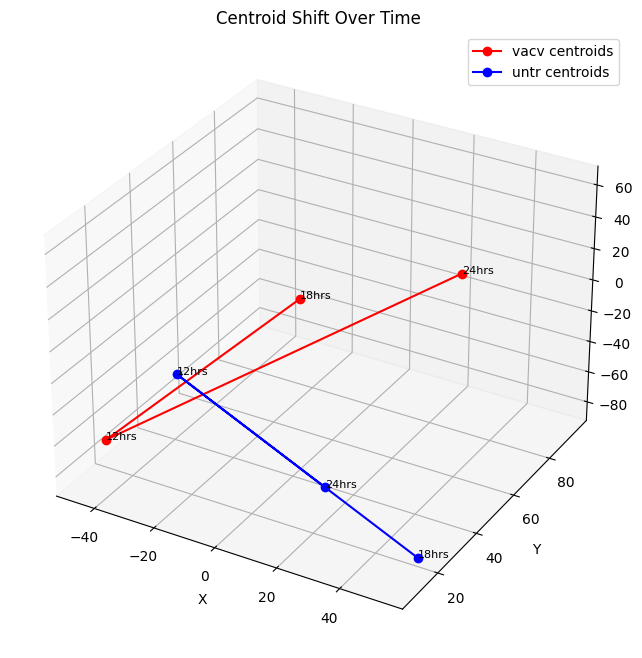

In [24]:
#centroid trajectory
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = {'vacv': 'red', 'untr': 'blue'}
for cond in ['vacv', 'untr']:
    sub = df_results[df_results['condition'] == cond]
    ax.plot(sub['centroid_x'], sub['centroid_y'], sub['centroid_z'],
            marker='o', color=colors[cond], label=f"{cond} centroids")
    for _, row in sub.iterrows():
        ax.text(row['centroid_x'], row['centroid_y'], row['centroid_z'],
                f"{row['time']}", fontsize=8)

ax.set_title("Centroid Shift Over Time")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()


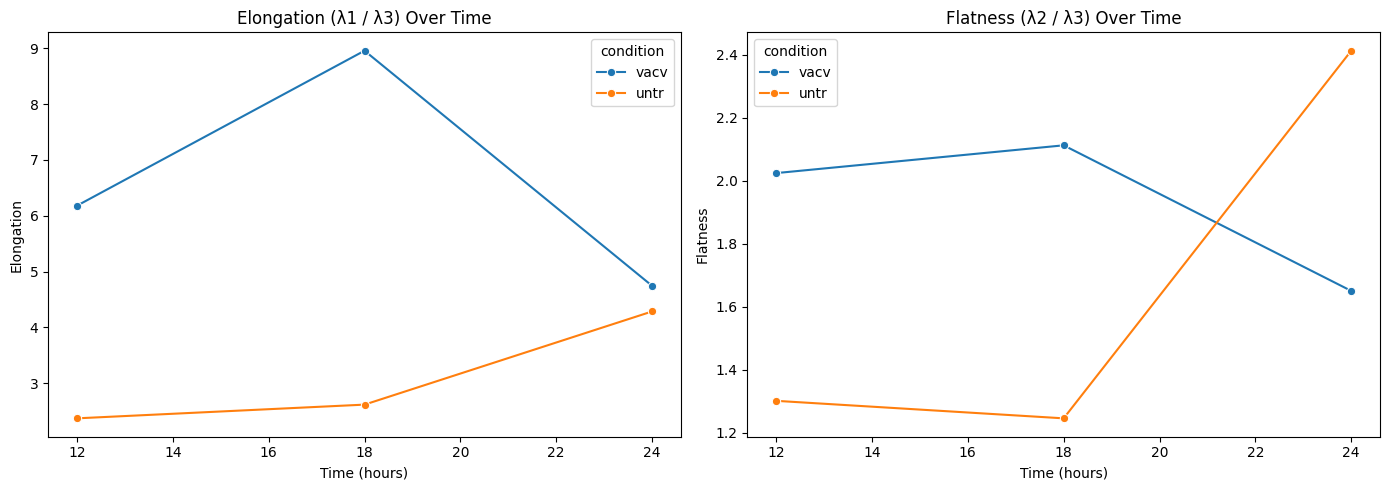

In [20]:
# Plot 2: Elongation and Flatness Over Time 
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.lineplot(data=df_results, x='time_num', y='elongation', hue='condition', marker='o', ax=axes[0])
axes[0].set_title("Elongation (λ1 / λ3) Over Time")
axes[0].set_xlabel("Time (hours)")
axes[0].set_ylabel("Elongation")

sns.lineplot(data=df_results, x='time_num', y='flatness', hue='condition', marker='o', ax=axes[1])
axes[1].set_title("Flatness (λ2 / λ3) Over Time")
axes[1].set_xlabel("Time (hours)")
axes[1].set_ylabel("Flatness")

plt.tight_layout()
plt.show()


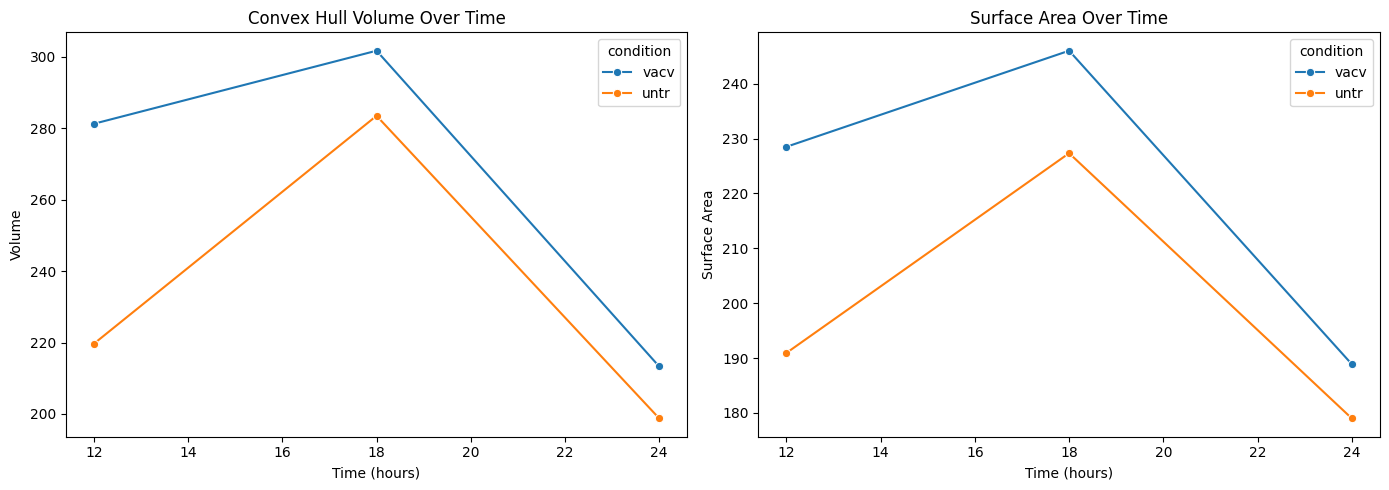

In [21]:
# Plot 3: Volume and Surface Area Over Time 
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.lineplot(data=df_results, x='time_num', y='volume', hue='condition', marker='o', ax=axes[0])
axes[0].set_title("Convex Hull Volume Over Time")
axes[0].set_xlabel("Time (hours)")
axes[0].set_ylabel("Volume")

sns.lineplot(data=df_results, x='time_num', y='surface_area', hue='condition', marker='o', ax=axes[1])
axes[1].set_title("Surface Area Over Time")
axes[1].set_xlabel("Time (hours)")
axes[1].set_ylabel("Surface Area")

plt.tight_layout()
plt.show()


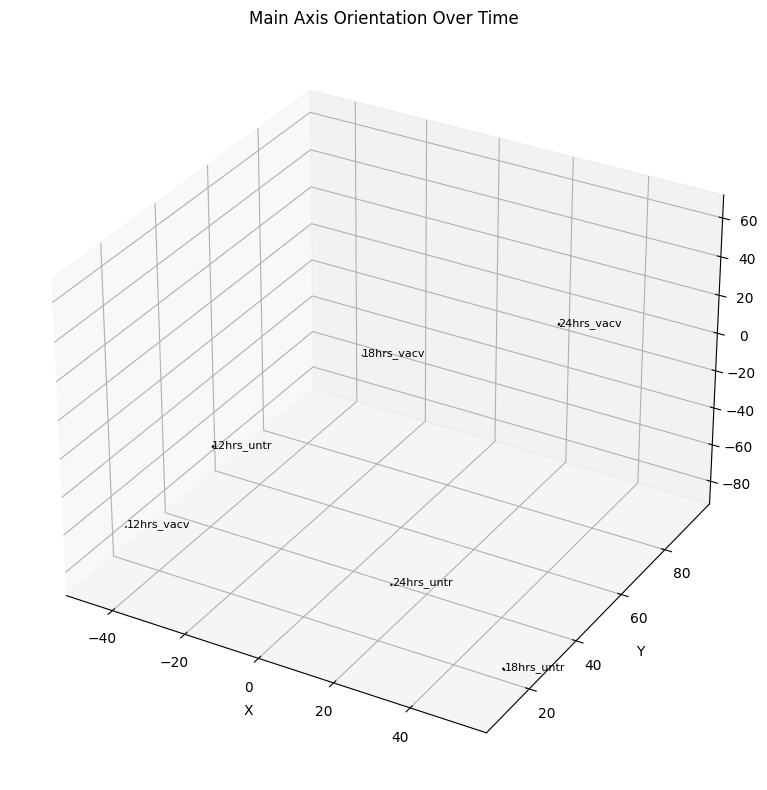

In [22]:
# Plot 4: Orientation Vector Field in 3D 
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for _, row in df_results.iterrows():
    start = np.array([row['centroid_x'], row['centroid_y'], row['centroid_z']])
    vec = np.array([row['orientation_x'], row['orientation_y'], row['orientation_z']])
    end = start + vec * 15  # scaled for visibility
    ax.quiver(start[0], start[1], start[2], vec[0], vec[1], vec[2],
              color='black', arrow_length_ratio=0.1)
    ax.text(start[0], start[1], start[2], f"{row['time']}_{row['condition']}", fontsize=8)

ax.set_title("Main Axis Orientation Over Time")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.tight_layout()
plt.show()
